# Dimensionality Reduction with the Proper Orthogonal Decomposition (POD)
This notebook takes the Snapshots and find the POD modes and the corresponding coefficients.

Let us create the mesh from the OpenFOAM nodes and cells, we are going to exploit the results from `Chapter3/BoundarySensing`

In [3]:
import sys
path_chap3 = '../../Chapter3/BoundarySensing/'
sys.path.append(path_chap3)

from pyforce.tools.write_read import ReadFromOF
from utils import create_mesh_dolfinx
from IPython.display import clear_output as clc

path_snaps = '../../../Data/MSFR/'
domain, ct, ft, gdim = create_mesh_dolfinx(path_snaps+'EVOL_geom_noreflector.geo')

Info    : Reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'...
Info    : Done reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 90%] Meshing cu

Let us import the snapshots, variable names and time

In [5]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load(path_chap3+'Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load(path_chap3+'Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, VectorElement("Lagrange", domain.ufl_cell(), 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load(path_chap3+'Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train, test and predict
\begin{equation}
    \left\{
        \begin{aligned}
            \Xi_{\text{train}} &= [0:0.025:20] \setminus[0.1:0.1:20] \\
            \Xi_{\text{test}} &= [0.1:0.1:20]\\
            \Xi_{\text{predict}} &= [20:0.025:25]\\
        \end{aligned}
    \right.
\end{equation}
such that $\Xi_{\text{train}}\cap \Xi_{\text{test}}=\emptyset$.

In [6]:
Nt = len(fom_times)
cut_train = int(0.8*Nt)

train_indices = np.arange(0, cut_train)
test_indices = train_indices[3::4]
train_indices = np.delete(train_indices, test_indices)

train_snaps = {field: FunctionsList(fun_spaces[field_i]) for field_i, field in enumerate(var_names)}
for field_i, field in enumerate(var_names):
    for ii in train_indices:
        train_snaps[field].append(snaps[field](ii))

## POD Training Phase
Let us compute the POD modes

In [9]:
from pyforce.offline.pod import POD

pod_offline = {
    field: POD(train_snap=train_snaps[field], name=field, verbose=True)
    for field in var_names
}

Computing T correlation matrix: 600.000 / 600.00 - 0.093 s/it
Computing U correlation matrix: 600.000 / 600.00 - 0.123 s/it
Computing flux correlation matrix: 600.000 / 600.00 - 0.094 s/it
Computing prec6 correlation matrix: 600.000 / 600.00 - 0.095 s/it


Let us plot the singular values and the cumulative energy

Text(0, 0.5, 'Residual energy')

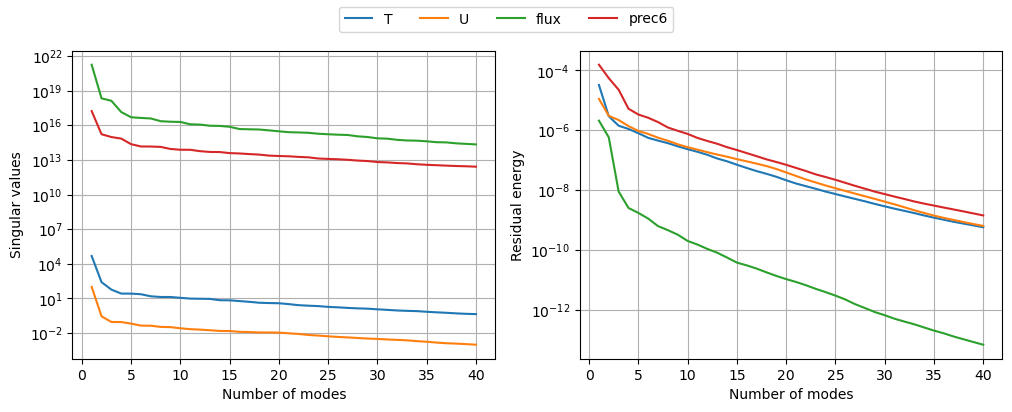

In [29]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12, 4))

Nplot=np.arange(1, 41)
for field in var_names:
    axs[0].semilogy(Nplot, np.sqrt(pod_offline[field].eigenvalues[:max(Nplot)]), label=field)
    axs[1].semilogy(Nplot, 1 - np.cumsum(pod_offline[field].eigenvalues)[:max(Nplot)]/np.sum(pod_offline[field].eigenvalues), label=field)

Lines, Labels = axs[0].get_legend_handles_labels()
fig.legend(Lines, Labels, loc='upper center', ncols=4)

for ax in axs:
    ax.set_xlabel('Number of modes')
    ax.grid()
axs[0].set_ylabel('Singular values')
axs[1].set_ylabel('Residual energy')

Let us generate and store the POD modes

In [36]:
max_rank = 15

for field in var_names:
    pod_offline[field].compute_basis(train_snap=train_snaps[field], maxBasis=15)

import os
from pyforce.tools.write_read import StoreFunctionsList

path_offline = 'Results/POD_offline/'
os.makedirs(path_offline, exist_ok=True)

for field in var_names:
    StoreFunctionsList(domain, pod_offline[field].PODmodes, f'POD_{field}_modes',
                       filename=path_offline+f'POD_{field}_modes')

Let us compure the training error and the POD coefficients

In [37]:
maxAbsErr = dict()
maxRelErr = dict()
alpha_coeffs = dict()

for field in var_names:
    maxAbsErr[field], maxRelErr[field], alpha_coeffs[field] = pod_offline[field].train_error(train_snaps[field], maxBasis=max_rank, verbose=True)

Computing train error T: 600.000 / 600.00 - 0.014 s/it
Computing train error U: 600.000 / 600.00 - 0.019 s/it
Computing train error flux: 600.000 / 600.00 - 0.015 s/it
Computing train error prec6: 600.000 / 600.00 - 0.015 s/it


Let us plot the decrease of the training error (absolute and relative)

Text(0, 0.5, 'Max Rel. Error')

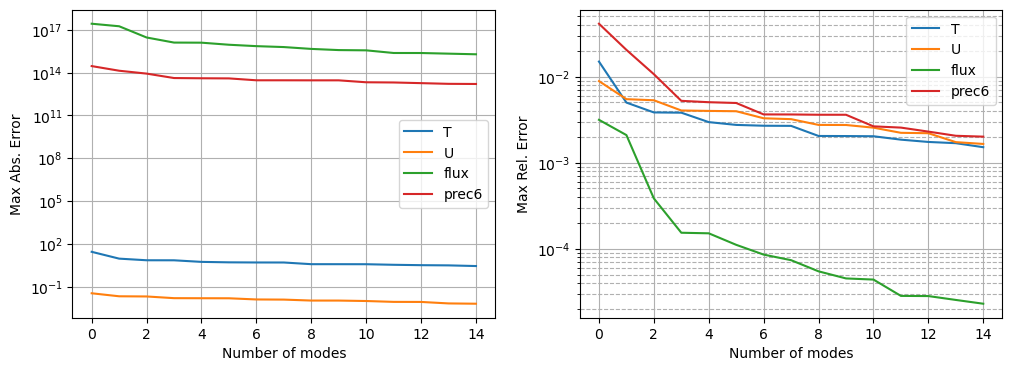

In [38]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(12, 4))

for field in var_names:
    axs[0].plot(maxAbsErr[field], label=field)
    axs[1].plot(maxRelErr[field], label=field)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Number of modes')
    ax.legend()
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')

axs[0].set_ylabel('Max Abs. Error')
axs[1].set_ylabel('Max Rel. Error')

Let us store the POD coefficients

In [40]:
for field in var_names:
    np.savez_compressed(path_offline+f'POD_{field}_TrainCoeffs', alpha_coeffs[field])

Let us plot the magic functions

[Text(0.5, 1.0, 'T'),
 Text(0.5, 1.0, 'U'),
 Text(0.5, 1.0, 'flux'),
 Text(0.5, 1.0, 'prec6')]

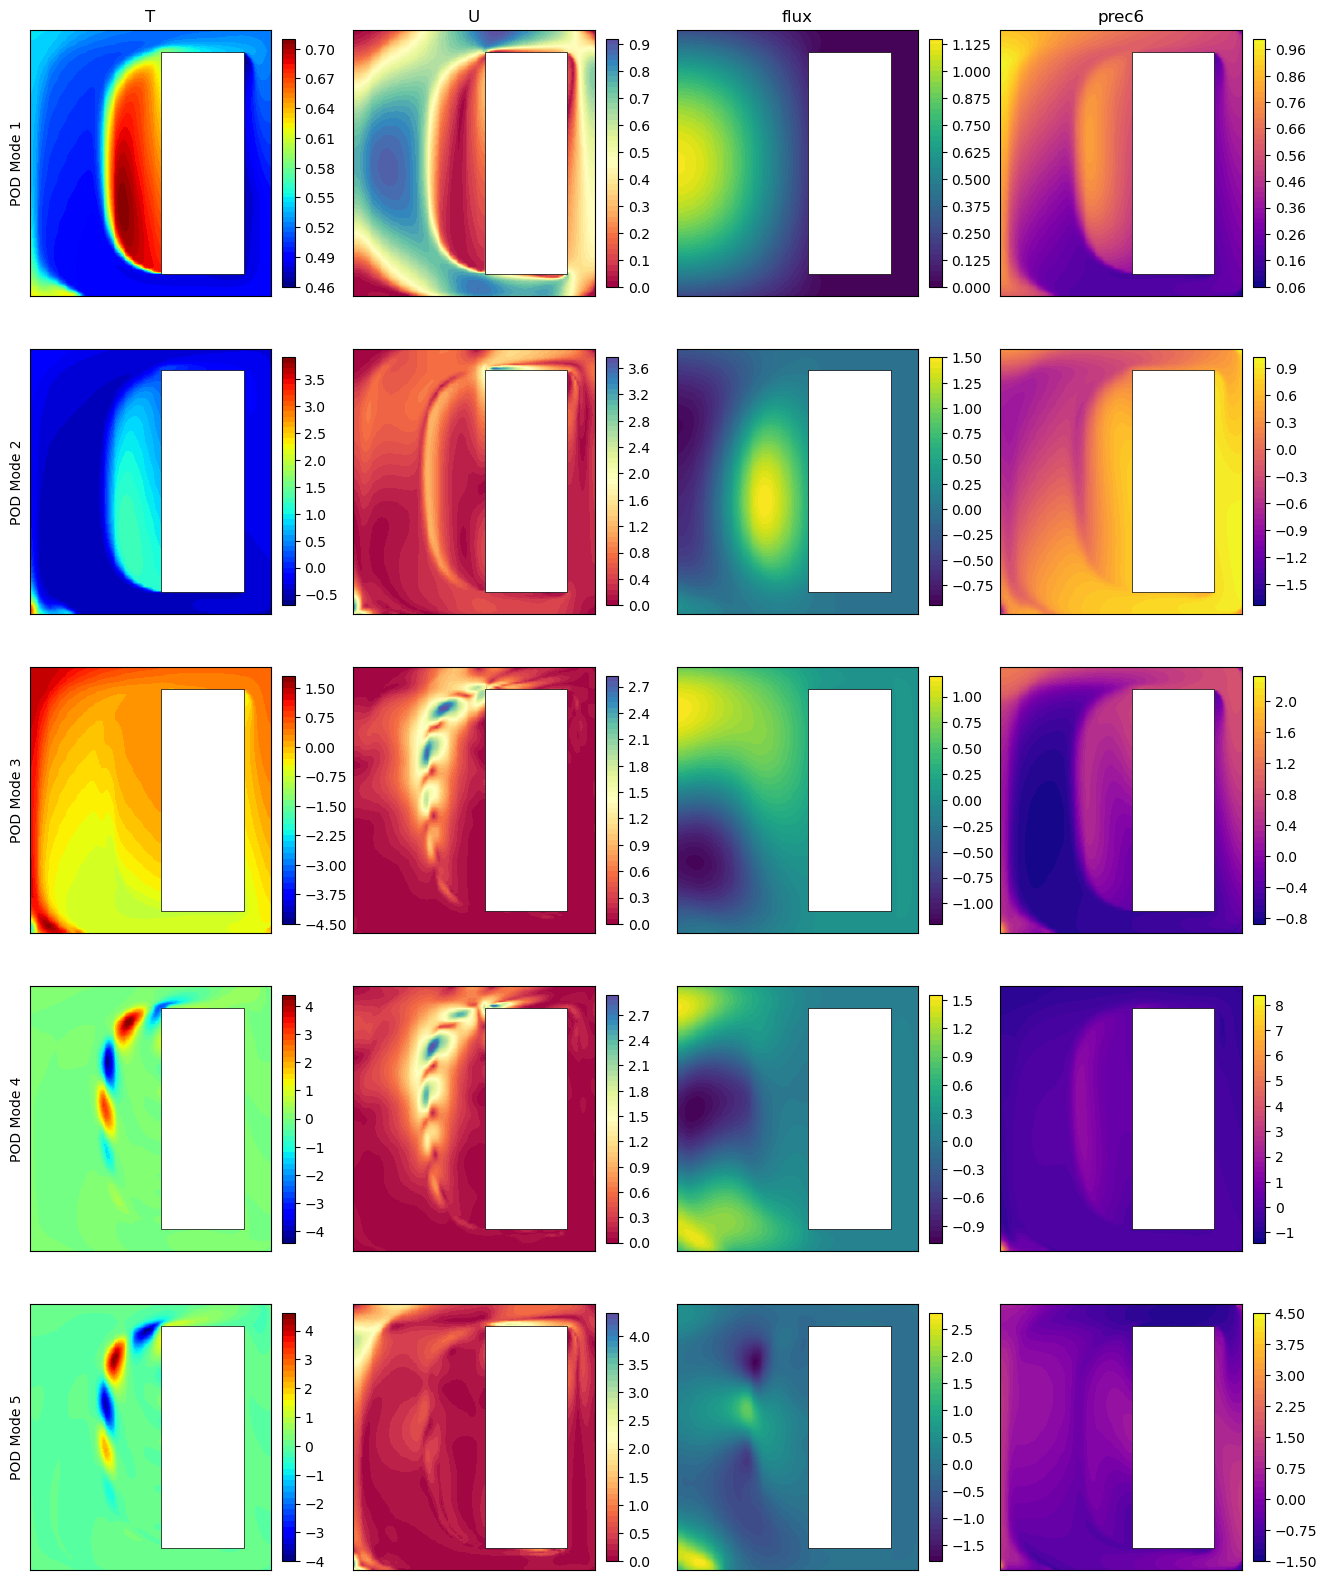

In [45]:
from utils import plot_contour
from matplotlib import cm

mode_to_plot = np.arange(0, 5, 1)

nrows = len(mode_to_plot)
ncols = len(var_names)

cmaps = [cm.jet, cm.Spectral, cm.viridis, cm.plasma]

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

for row in range(nrows):
    for col, field in enumerate(var_names):
        mode = pod_offline[field].PODmodes(mode_to_plot[row])
        vec_mode_to_plot = True if is_vector[col] else None
        cont = plot_contour(axs[row, col], domain.geometry.x[:, :2], mode, levels=50, vec_mode_to_plot=vec_mode_to_plot, cmap=cmaps[col])
        cbar = fig.colorbar(cont, ax=axs[row, col], fraction=0.046, pad=0.04)
    axs[row, 0].set_ylabel(f'POD Mode {mode_to_plot[row]+1}')

[axs[0, col].set_title(var_names[col]) for col in range(ncols)]